# SSDF master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3, venn2

from herschelhelp_internal.masterlist import (nb_compare_mags, nb_ccplots, nb_histograms, find_last_ml_suffix,
                                              quick_checks)

In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_ssdf_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_ssdf_20180221.fits


## 0 - Quick checks

In [4]:
quick_checks(master_catalogue).show_in_notebook()

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(80, False) will return an array of dtype('bool')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(80, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Table shows only problematic columns.


idx,Column,All nan,#Measurements,#Zeros,#Negative,Minimum value


## I - Summary of wavelength domains

In [5]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


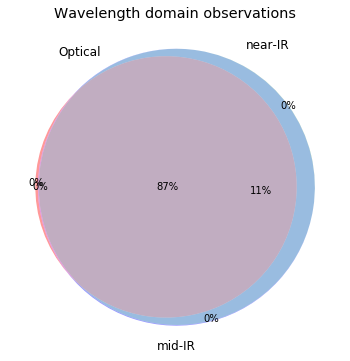

In [6]:
venn3(
    [
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 6),
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 5),
        np.sum(flag_obs == 3),
        np.sum(flag_obs == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

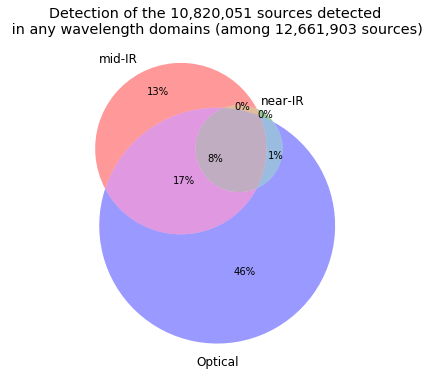

In [7]:
venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('mid-IR', 'near-IR',  'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [8]:
g_bands = ["DECam g"]
r_bands = ["DECam r"]
i_bands = ["DECam i"]
z_bands = ["DECam z"]
y_bands = ["DECam y"]
j_bands =           [ "VISTA J"]
h_bands =           [ "VISTA H"]
k_bands =           [ "VISTA Ks"]
irac_bands =                    ["IRAC I1", "IRAC I2"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

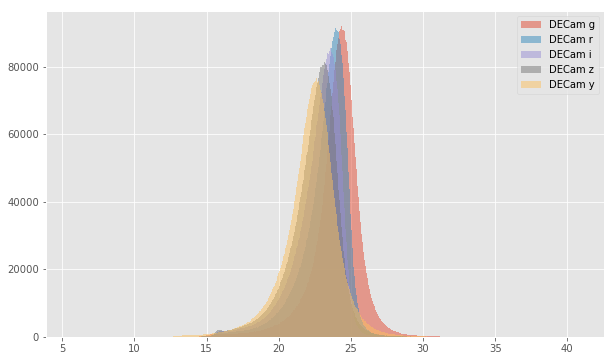

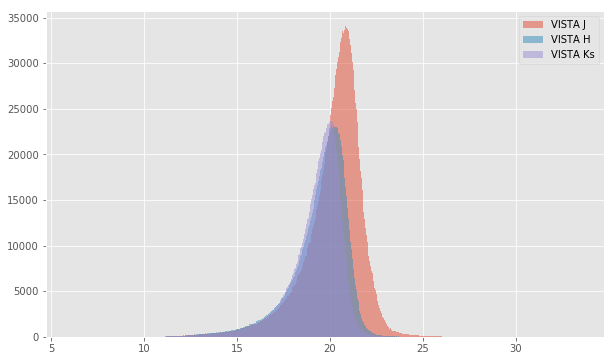

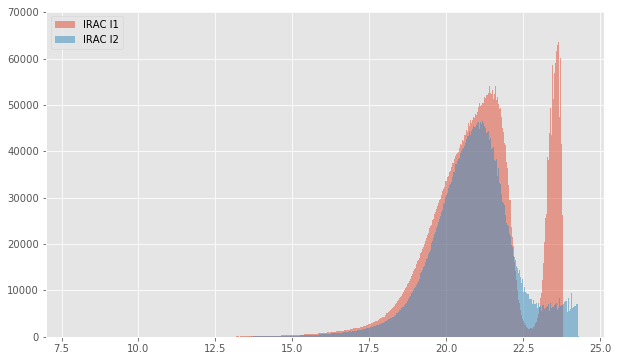

In [9]:
for bands in [g_bands + r_bands + i_bands + z_bands + y_bands, j_bands + h_bands + k_bands, irac_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

There are no similar bands from different instruments.

In [10]:
# for band_of_a_kind in [j_bands, h_bands, k_bands]:
#     for band1, band2 in itertools.combinations(band_of_a_kind, 2):
#         
#         basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
#         
#         col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
#         nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
#                         labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
#         
#         col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
#         nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
#                         labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to SDSS.

In [11]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |


In [12]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [13]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_SSDF.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

VISTA J (total) - 2MASS J:
- Median: 0.03
- Median Absolute Deviation: 0.06
- 1% percentile: -0.9993877432157341
- 99% percentile: 0.7214355603120987


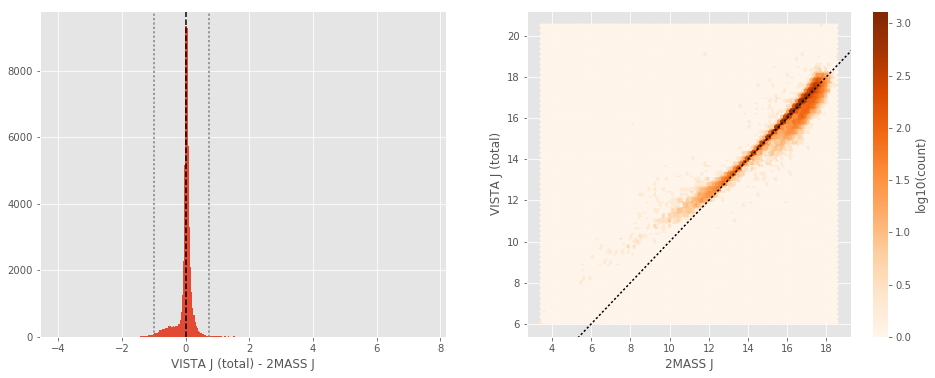

In [14]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_vista_j'][ml_twomass_idx],
                labels=("2MASS J", "VISTA J (total)"))

VISTA Ks (total) - 2MASS Ks:
- Median: 0.04
- Median Absolute Deviation: 0.09
- 1% percentile: -0.9690106682451767
- 99% percentile: 0.9662497443524783


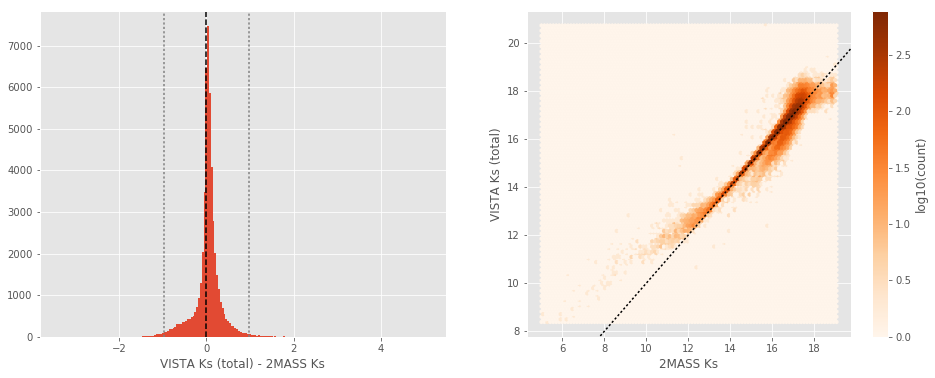

In [15]:
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, master_catalogue['m_vista_ks'][ml_twomass_idx],
                labels=("2MASS Ks", "VISTA Ks (total)"))

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 2057720 / 12661903 (16.25%)


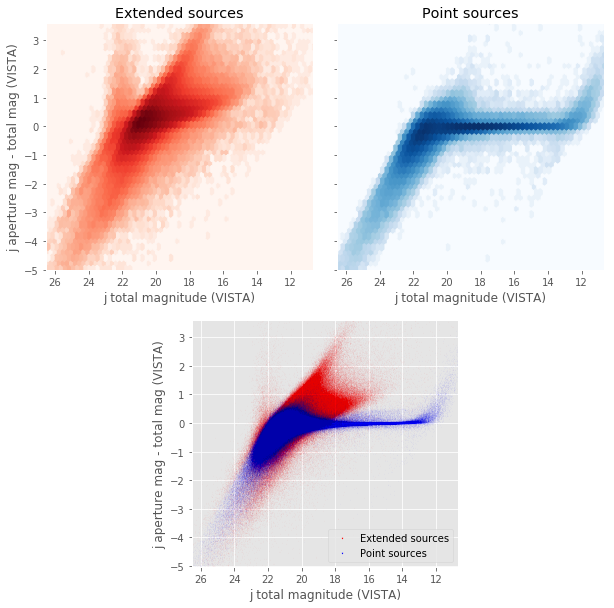

In [16]:
nb_ccplots(
    master_catalogue['m_vista_j'],
    master_catalogue['m_ap_vista_j'] - master_catalogue['m_vista_j'],
    "j total magnitude (VISTA)", "j aperture mag - total mag (VISTA)",
    master_catalogue["stellarity"],
    invert_x=True
)

Number of source used: 4239455 / 12661903 (33.48%)


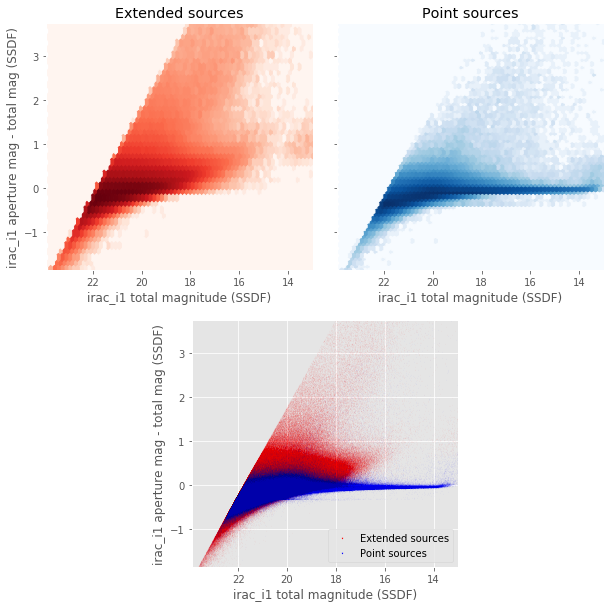

In [17]:
nb_ccplots(
    master_catalogue['m_irac_i1'],
    master_catalogue['m_ap_irac_i1'] - master_catalogue['m_irac_i1'],
    "irac_i1 total magnitude (SSDF)", "irac_i1 aperture mag - total mag (SSDF)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 745557 / 12661903 (5.89%)


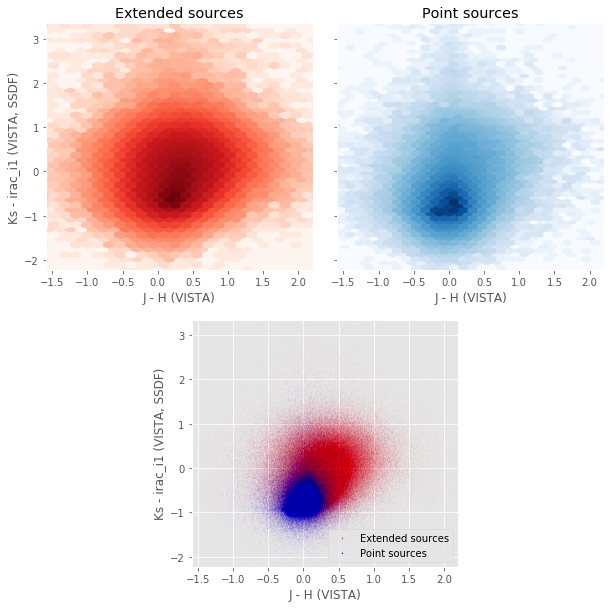

In [18]:
nb_ccplots(
    master_catalogue['m_vista_j'] - master_catalogue['m_vista_h'],
    master_catalogue['m_vista_ks'] - master_catalogue['m_irac_i1'],
    "J - H (VISTA)", "Ks - irac_i1 (VISTA, SSDF)",
    master_catalogue["stellarity"]
)

Number of source used: 797742 / 12661903 (6.30%)


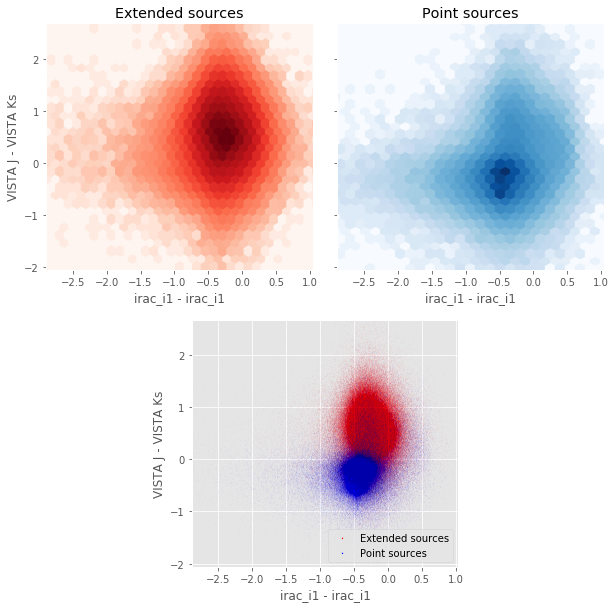

In [19]:
nb_ccplots(
    master_catalogue['m_irac_i1'] - master_catalogue['m_irac_i2'],
    master_catalogue['m_vista_j'] - master_catalogue['m_vista_ks'],
    "irac_i1 - irac_i1", "VISTA J - VISTA Ks",
    master_catalogue["stellarity"]
)